#### Example. Random generated data

##### 1. generate data

In [106]:
# list of points
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [3, 1]]
cov = [[.3, .2], [.2, .3]]
N = 100
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)

X1[-1, :] = [2.7, 2] # change to make sure at least one point is misplaced 
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

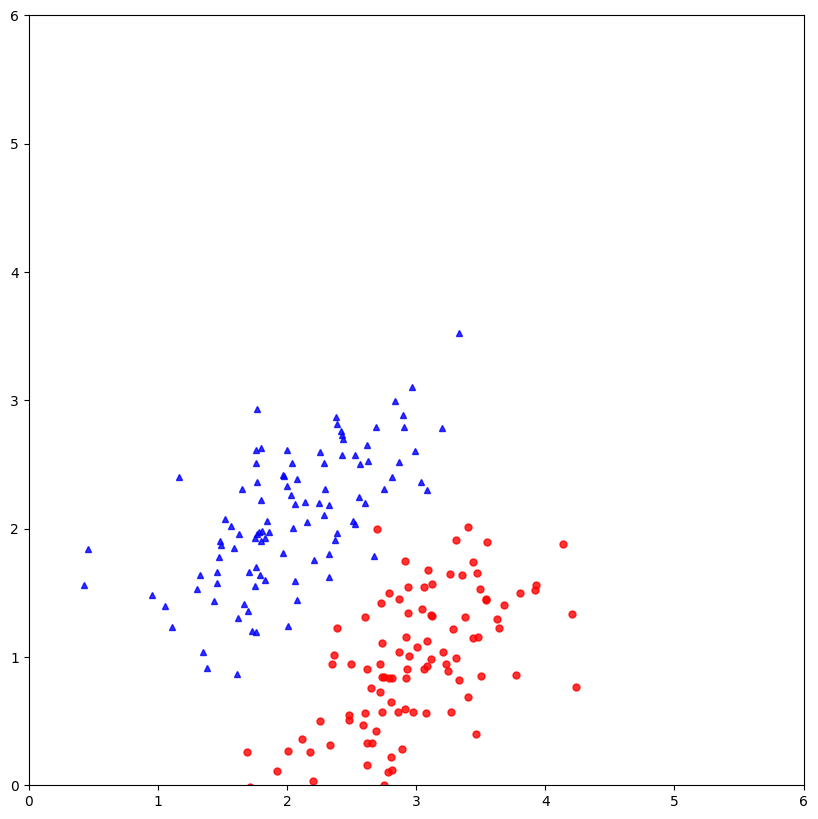

In [10]:
# visualize 2d
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([0 , 6, 0, 6])
plt.show()

##### 2. solve using quadratic programming

In [107]:
from cvxopt import matrix, solvers

C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[7.40072546e-08 1.91607390e-07 1.38875311e+01 7.97994212e-08
  6.89508163e-08 3.98805625e-08 1.02247228e-07 8.91558791e-08
  6.11176818e-08 6.87142408e-08 1.58616901e-07 9.99999989e+01
  6.31608259e-08 4.75316553e-08 5.07776806e-08 4.21753680e-08
  6.06648131e+01 4.13912060e-08 4.59302903e-08 6.20253903e-08
  6.20905376e-08 3.45674164e-08 9.53161952e-08 1.58377198e-07
  2.82899282e-07 4.97335537e-08 5.30507016e-08 4.97044350e-08
  4.04110496e-08 3.62269915e-08 4.95176976e-08 8.96224612e-08
  4.52194912e-08 7.47989742e-08 5.41851771e-08 6.05917136e-08
  5.16209379e-07 2.73708852e-08 2.85816793e-08 9.43531343e-08
  1.73875399e-07 5.86717736e-08 5.02212314e-08 4.89985797e-08
  1.52766425e-07 1.88427022e-07 3.40090449e-08 5.78497059e-08
  2.85602841e-08 1.57609429e-07 1.09966838e-07 5.50802808e-08
  5.07238270e-08 4.98001330e-08 1.47055333e-07 5.98956818e-08
  1.43396499e-07 1.51070328e-07 8.44247949e-08 1.55370772e-07
  4.39171902e-08 6.16571169e-08 1.15552379e-07 7.32081392e-

In [40]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]

M = np.array([val for val in S if val in S2]) # intersection of two lists

XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[0][M]

XM = XT[M]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM.T))
print(w_dual.T, b_dual)

[[-5.07603023  5.15396033]] 4.795150755696481


##### 3. solve using unconstrained programming

In [44]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

In [45]:
def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + 
            .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias

In [46]:
def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g

In [47]:
eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps

        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g

In [48]:
w0 = np.random.randn(X0_bar.shape[0], 1)
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

Gradient different: 0.000000


In [49]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w

w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12464\3174740377.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 1 cost: 517.738815
iter 10001 cost: 3.280800
iter 20001 cost: 3.241315
iter 30001 cost: 3.231145
iter 40001 cost: 3.230590
iter 50001 cost: 3.230544
iter 60001 cost: 3.230498
iter 70001 cost: 3.240517
iter 80001 cost: 3.230341
iter 90001 cost: 3.241648
[[-5.07362939  5.149011  ]] [4.79059187]


##### 4. solve using sklearn

In [41]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C

# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-5.07509054  5.1523768 ]]
b =  [4.7875035]


##### 5. predict

compute using theoretical formula

In [84]:
# predict
pred = np.sign(w_dual.T.dot(X) + b_dual)

# accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

print(accuracy_score(y[0], pred[0]))
print(precision_score(y[0], pred[0]))
print(recall_score(y[0], pred[0]))
print(confusion_matrix(y[0], pred[0]))

0.995
0.9900990099009901
1.0
[[ 99   1]
 [  0 100]]


SVC predict function

In [88]:
y_pred = clf.predict(X.T)

print(accuracy_score(y[0], y_pred))
print(precision_score(y[0], y_pred))
print(recall_score(y[0], y_pred))
print(confusion_matrix(y[0], y_pred))

0.995
0.9900990099009901
1.0
[[ 99   1]
 [  0 100]]


#### Exercise 1. Brease Cancer

##### 1. load and split data

In [89]:
from sklearn import datasets

cancer_data = datasets.load_breast_cancer()
# show to test record 5th
print(cancer_data.data[5])
print(cancer_data.data.shape)
#target set
print(cancer_data.target)

[1.245e+01 1.570e+01 8.257e+01 4.771e+02 1.278e-01 1.700e-01 1.578e-01
 8.089e-02 2.087e-01 7.613e-02 3.345e-01 8.902e-01 2.217e+00 2.719e+01
 7.510e-03 3.345e-02 3.672e-02 1.137e-02 2.165e-02 5.082e-03 1.547e+01
 2.375e+01 1.034e+02 7.416e+02 1.791e-01 5.249e-01 5.355e-01 1.741e-01
 3.985e-01 1.244e-01]
(569, 30)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 

In [123]:
y = cancer_data.target
y[cancer_data.target == 0] = -1

In [124]:
from sklearn.model_selection import train_test_split
cancer_data = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, y, test_size=0.3, random_state=109)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(398, 30)
(171, 30)
(398,)
(171,)


##### 2. classification using SVM

method 1. quadratic programming

In [156]:
from cvxopt import matrix, solvers

C = 100
N = len(X_train)
X0 = X_train[y_train == 1]
X1 = X_train[y_train == -1]
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(N), np.eye(N))))

h = matrix(np.vstack((np.zeros((N, 1)), C*np.ones((N, 1)))))
A = matrix(y_train.reshape((-1, N)))
A = A * 1.0
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[6.70932523e-166 4.53460215e+001 4.89659478e-166 5.69968140e+001
  1.13809504e-165 4.52420434e-165 4.56728750e-165 1.63992420e-165
  8.89389477e-166 2.31151807e-165 1.33053366e-165 1.48769637e-165
  1.25373070e-165 7.91595596e-166 7.32499582e-166 1.77647746e-165
  3.68412402e-164 6.96447875e-166 2.90472219e-165 1.11360941e-165
  1.91696309e-165 4.70823582e-166 7.00520903e+001 7.10506554e-165
  5.84759946e-166 1.27071469e-165 1.77349591e-165 7.68412804e-166
  9.62315264e-166 1.36488076e-165 9.52648331e-166 1.49491315e-165
  3.07524327e-165 1.12188928e-165 1.00000000e+002 8.20359112e-166
  9.19835236e-166 1.00970223e-165 9.91888936e-166 1.03540399e-164
  1.41210603e-165 1.05974209e-165 1.16040114e-165 2.46434406e-165
  1.00974008e-164 2.94523944e-165 8.70894776e-166 7.61650142e-166
  1.20268881e-165 8.51523718e-166 8.60795651e-166 1.93875590e-165
  8.21312557e-166 1.00000000e+002 8.09471253e+001 6.71463777e-166
  2.52676666e-165 1.12679288e-165 3.97005285e-165 1.24122679e-165

In [157]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]

M = np.array([val for val in S if val in S2]) # intersection of two lists

XT = X_train # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y_train[M]

XM = XT[M]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM.T))
print(w_dual.T, b_dual)

[[ 5.70946557e+00  9.65314478e-02 -6.34394233e-01 -1.16806821e-02
  -2.77209427e+00  2.46393816e+00 -4.13759832e+00 -1.15228505e+01
  -2.18593645e+00  2.60007716e+00 -1.93049208e+00  2.04519967e+00
  -2.24488565e-01 -7.57883861e-02 -7.43148334e-01  7.43841049e+00
   1.48107737e+01 -8.48537919e-01  1.84065190e+00  9.52178214e-01
   2.44141703e-01 -4.12761218e-01  8.79229502e-02 -1.68115509e-02
  -6.46206922e+00  6.51015897e+00 -3.94241934e+00 -1.79218731e+01
  -7.36626109e+00  3.55560447e+00]] 1.3577242543886807


In [158]:
# predict
pred = np.sign(w_dual.T.dot(X_test.T) + b_dual)

# accuracy
print(accuracy_score(y_test, pred[0]))
print(precision_score(y_test, pred[0]))
print(recall_score(y_test, pred[0]))
print(confusion_matrix(y_test, pred[0]))

0.9766081871345029
0.9727272727272728
0.9907407407407407
[[ 60   3]
 [  1 107]]


method 2. sklearn

In [155]:
from sklearn.svm import SVC
# Copy and put code for generate data here
clf = SVC(kernel = 'linear', C = 100) # use the same C

# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X_train, y_train)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[ 2.10521722e+01  2.24748032e+00 -1.77289515e+00  9.15979932e-03
  -7.50191113e+00 -4.34135814e+00 -2.25615033e+01 -1.61915137e+01
  -1.98778939e+01  5.08582453e-01 -5.57421339e+00  3.81134692e+01
  -3.92642593e+00 -1.62481781e+00 -1.18075377e+00  4.61362104e+00
  -2.22012715e+00 -3.35024280e+00 -5.99961781e+00  4.40746460e-01
   7.64788284e+00 -6.07125451e+00  2.54344789e-01 -2.28639058e-01
  -1.32196351e+01  1.01949892e+01 -4.05023829e+01 -3.32636060e+01
  -6.20170690e+01  1.96239360e+00]]
b =  [71.50077318]


In [151]:
# predict
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9707602339181286
0.9904761904761905
0.9629629629629629
[[ 62   1]
 [  4 104]]
